In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm, trange

In [2]:
from itertools import chain
from tqdm.notebook import tqdm

In [3]:
from gensim.models import Word2Vec

In [4]:
import metrics 

Вторая часть дз, которую я к сожалению не успел довычислить(

In [5]:
train = pd.read_csv('./data/train.csv')

In [6]:
# train = train.iloc[:25_000]

In [7]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [8]:
songs = pd.read_csv('./data/songs.csv')

In [9]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [10]:
data = train.merge(songs)

In [11]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,e5Ezre9HPuPos+CXQXtmo32E/hHIZTMmo6jG3yRf6UA=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-playlist,1,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
2,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
3,sSexP400TJOZRhx3JB+0s9cqrCnqrlV51B9njoKR1II=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
4,hKdGiUKHVqKkXGHLrc+EzdSW6q0ERAJ2Cs7/L1N0Ae4=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,NaN,online-playlist,0,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0


In [12]:
songs_ids, id_cnts = np.unique(data.song_id, return_counts=True)
songs_ids = set(songs_ids[id_cnts>5])

mask = [not(el in songs_ids) for el in data.song_id]
data.loc[mask, 'song_id'] = 'unknown'

In [13]:
sessions = dict(data.groupby("msno").song_id.apply(list))
sentences = [values for values in sessions.values() if len(values) > 0]
songs_embeddings = Word2Vec(sentences=sentences, vector_size=512, window=5,   
                                 min_count=5, seed=0)

In [14]:
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.model_selection import GroupKFold, KFold

In [15]:
fit_bs, tr_bs = 10_000, 1000
top_genres = data["genre_ids"].value_counts().index[1:5].to_list()

genres_mask = data["genre_ids"].isin(top_genres)
knonw_mask = data.song_id != 'unknown'

mask = knonw_mask & genres_mask
songs = data[mask].song_id
genres = data[mask].genre_ids.to_numpy()

embs = songs_embeddings.wv[songs]
pca = IncrementalPCA(n_components=2,batch_size=fit_bs)
pca.fit(embs)

transformed_embs = []
for i in trange(len(embs)//tr_bs + 1):
    transformed_embs.extend(pca.transform(embs[i*tr_bs:(i+1)*tr_bs]))
transformed_embs = np.array(transformed_embs)

  0%|          | 0/2104 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

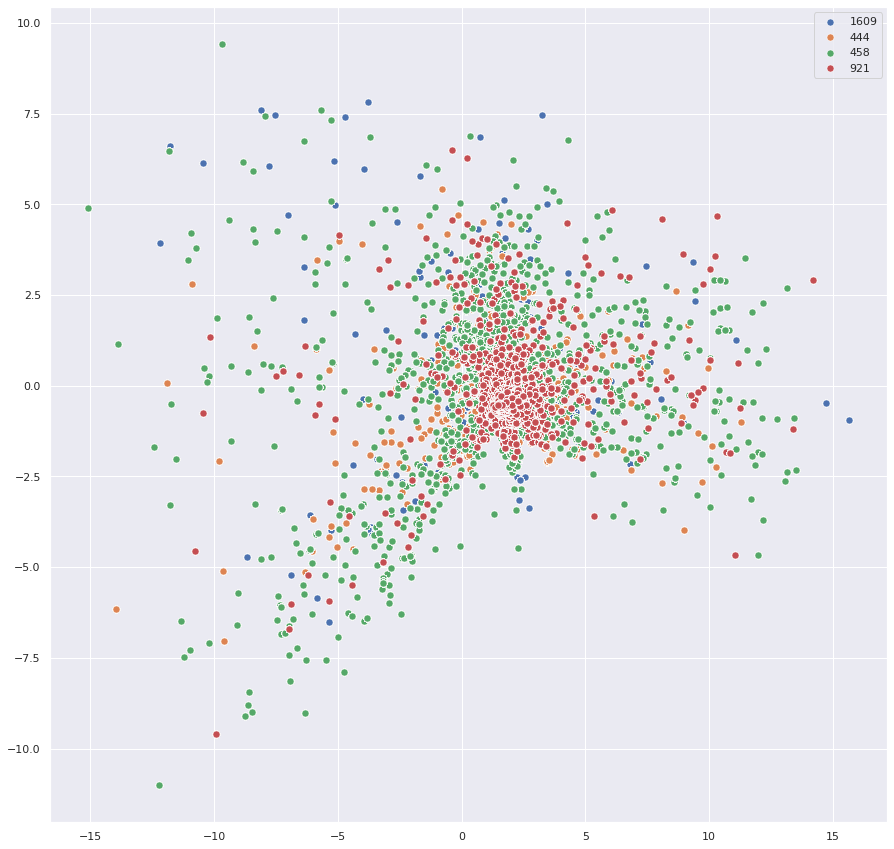

In [16]:
sns.set_theme(rc={"figure.figsize": (15, 15)})

for g in tqdm(np.unique(genres)):
    cur_mask = genres == g
    sns.scatterplot(x=transformed_embs[cur_mask, 0], y=transformed_embs[cur_mask, 1], label=g, s=50)

С одной стороны, здорово,что треки внутри одного жанра и правда похожи. Плохо, что песни разных жанров близки. Но кажется это легко объяснимо тем, что пользователи на самом деле предпочитают слушать разную музыку.

In [17]:
def check_song_id_in_vocab(song_id: str):
    return song_id in songs_embeddings.wv

In [18]:
def get_user_embedding(sub_data, songs_embeddings):
    user_embeddings = {}
    positive_sessions = dict(sub_data[sub_data.target == 1].groupby("msno").song_id.apply(list))
    
    user_set = set(list(positive_sessions.keys()))
    for user, user_positives in tqdm(positive_sessions.items()):
        user_positives = [positive for positive in user_positives]
        if len(user_positives) > 0:
            user_embeddings[user] = songs_embeddings.wv[user_positives].mean(axis=0)
        
    return user_embeddings, user_set

In [19]:
def train(sub_data):
    songs_ids, id_cnts = np.unique(sub_data.song_id, return_counts=True)
    songs_ids = set(songs_ids[id_cnts>5])

    mask = [not(el in songs_ids) for el in sub_data.song_id]
    sub_data.loc[mask, 'song_id'] = 'unknown'

    sessions = dict(sub_data.groupby("msno").song_id.apply(list))
    sentences = [values for values in sessions.values() if len(values) > 0]
    songs_embeddings = Word2Vec(sentences=sentences, vector_size=512, window=5, min_count=5, seed=0)
    
    user_embeddings, user_set = get_user_embedding(sub_data, songs_embeddings)
    
    return songs_embeddings, user_embeddings

In [20]:
def predict(sub_data, songs_embeddings, user_embeddings):
    users_names = sub_data.msno.to_numpy()
    songs_ids = sub_data.song_id.to_numpy()
    
    scores = np.zeros(len(sub_data))
    
    print(len(songs_ids), 
          sum([(user in user_embeddings.keys()) for user in songs_ids]),
          sum([check_song_id_in_vocab(song) for song in songs_ids]))
    mask = np.array([(user in user_embeddings.keys()) and check_song_id_in_vocab(song)
                 for user, song in zip(users_names, songs_ids)])
    sub_embs_user = np.array([user_embeddings[el] for el in users_names[mask]])
    sub_embs_song = np.array([songs_embeddings.wv[el] for el in songs_ids[mask]])
    
    
    # за даталик извиняюсь
    scores[mask] = np.sum(sub_embs_user * sub_embs_song, axis=1)
    
    y = sub_data['target'].values
    queries = sub_data['msno'].values
    
    return metrics.ndcg(queries, scores, y), metrics.auc_per_query(queries, scores, y)

In [21]:
group_kfold = KFold(n_splits=5)

data = data.sort_values(by='msno')
groups = data.msno.to_numpy()

scores = {'ndcg': [], 'auc': []}
for train_index, test_index in group_kfold.split(data, groups=groups):
    train_dataset = data.iloc[train_index]
    test_dataset = data.iloc[test_index]
    
    songs_embeddings, user_embeddings = train(train_dataset)
    ndcg, auc = predict(test_dataset, songs_embeddings, user_embeddings)
    scores['ndcg'].append(ndcg)
    scores['auc'].append(auc)

/home/stas/venvs/main39/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


KeyboardInterrupt: 